In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional


df = pd.read_csv('weatherHistory.csv')
data = df['Temperature (C)'].values
data = data.reshape(-1, 1)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)



In [6]:
look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features] for RNN and LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [11]:
# RNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(look_back, 1)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae','accuracy'])
rnn_model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1)

# Vanilla LSTM Model
vanilla_lstm_model = Sequential()
vanilla_lstm_model.add(LSTM(50, input_shape=(look_back, 1)))
vanilla_lstm_model.add(Dense(1))
vanilla_lstm_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae','accuracy'])
vanilla_lstm_model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1)

# Stacked LSTM Model
stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
stacked_lstm_model.add(LSTM(50, return_sequences=False))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae','accuracy'])
stacked_lstm_model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1)

# Bidirectional LSTM Model
bidirectional_lstm_model = Sequential()
bidirectional_lstm_model.add(Bidirectional(LSTM(50, input_shape=(look_back, 1))))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae','accuracy'])
bidirectional_lstm_model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1)

# Predictions
rnn_predictions = rnn_model.predict(X_test)
vanilla_lstm_predictions = vanilla_lstm_model.predict(X_test)
stacked_lstm_predictions = stacked_lstm_model.predict(X_test)
bidirectional_lstm_predictions = bidirectional_lstm_model.predict(X_test)

# Inverse transform predictions
rnn_predictions = scaler.inverse_transform(rnn_predictions)
vanilla_lstm_predictions = scaler.inverse_transform(vanilla_lstm_predictions)
stacked_lstm_predictions = scaler.inverse_transform(stacked_lstm_predictions)
bidirectional_lstm_predictions = scaler.inverse_transform(bidirectional_lstm_predictions)
y_test_inverse = scaler.inverse_transform([y_test])




Epoch 1/3
2411/2411 [==============================] - 27s 11ms/step - loss: 0.0011 - mae: 0.0215 - accuracy: 2.5923e-05
Epoch 2/3
2411/2411 [==============================] - 25s 11ms/step - loss: 6.0661e-04 - mae: 0.0162 - accuracy: 2.5923e-05
Epoch 3/3
2411/2411 [==============================] - 25s 10ms/step - loss: 5.9834e-04 - mae: 0.0160 - accuracy: 2.5923e-05
Epoch 1/3
2411/2411 [==============================] - 25s 8ms/step - loss: 0.0027 - mae: 0.0328 - accuracy: 2.5923e-05
Epoch 2/3
2411/2411 [==============================] - 18s 7ms/step - loss: 6.5953e-04 - mae: 0.0174 - accuracy: 2.5923e-05
Epoch 3/3
2411/2411 [==============================] - 18s 7ms/step - loss: 6.0604e-04 - mae: 0.0163 - accuracy: 2.5923e-05
Epoch 1/3
2411/2411 [==============================] - 29s 11ms/step - loss: 0.0025 - mae: 0.0306 - accuracy: 2.5923e-05
Epoch 2/3
2411/2411 [==============================] - 26s 11ms/step - loss: 6.3612e-04 - mae: 0.0169 - accuracy: 2.5923e-05
Epoch 3/3
2411/

RNN - MAE: 0.8195918655132833, RMSE: 1.2088472237164607, MAPE: 2300786642655.44
Vanilla LSTM - MAE: 0.7740599677014447, RMSE: 1.1931139129183481, MAPE: 1643421681587.833
Stacked LSTM - MAE: 0.8187526316509839, RMSE: 1.2145566948151418, MAPE: 2003890206919.204
Bidirectional LSTM - MAE: 0.8285623530153498, RMSE: 1.2457294338464944, MAPE: 1378056709619.129


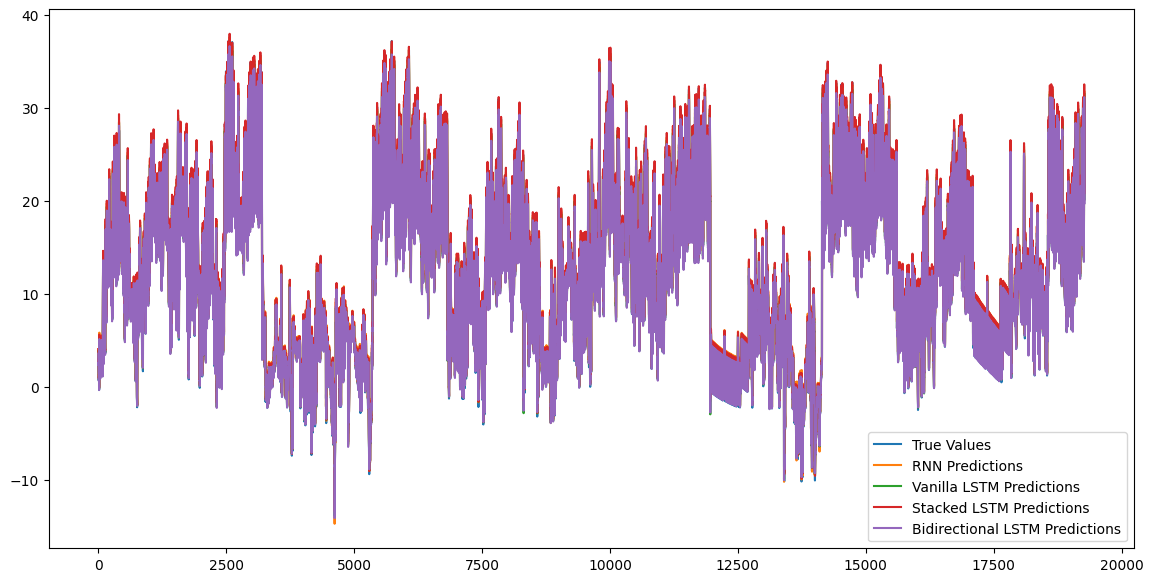

In [12]:

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, rmse, mape

rnn_mae, rnn_rmse, rnn_mape = evaluate_model(y_test_inverse[0], rnn_predictions[:, 0])
vanilla_lstm_mae, vanilla_lstm_rmse, vanilla_lstm_mape = evaluate_model(y_test_inverse[0], vanilla_lstm_predictions[:, 0])
stacked_lstm_mae, stacked_lstm_rmse, stacked_lstm_mape = evaluate_model(y_test_inverse[0], stacked_lstm_predictions[:, 0])
bidirectional_lstm_mae, bidirectional_lstm_rmse, bidirectional_lstm_mape = evaluate_model(y_test_inverse[0], bidirectional_lstm_predictions[:, 0])


print(f"RNN - MAE: {rnn_mae}, RMSE: {rnn_rmse}, MAPE: {rnn_mape}")
print(f"Vanilla LSTM - MAE: {vanilla_lstm_mae}, RMSE: {vanilla_lstm_rmse}, MAPE: {vanilla_lstm_mape}")
print(f"Stacked LSTM - MAE: {stacked_lstm_mae}, RMSE: {stacked_lstm_rmse}, MAPE: {stacked_lstm_mape}")
print(f"Bidirectional LSTM - MAE: {bidirectional_lstm_mae}, RMSE: {bidirectional_lstm_rmse}, MAPE: {bidirectional_lstm_mape}")


plt.figure(figsize=(14,7))
plt.plot(y_test_inverse[0], label='True Values')
plt.plot(rnn_predictions[:,0], label='RNN Predictions')
plt.plot(vanilla_lstm_predictions[:,0], label='Vanilla LSTM Predictions')
plt.plot(stacked_lstm_predictions[:,0], label='Stacked LSTM Predictions')
plt.plot(bidirectional_lstm_predictions[:,0], label='Bidirectional LSTM Predictions')
plt.legend()
plt.show()

In [13]:
# Print actual vs predicted temperatures for RNN
rnn_actual_vs_predicted = pd.DataFrame({
    'Actual': y_test_inverse[0],
    'RNN Predicted': rnn_predictions[:, 0]
})
print("RNN Actual vs Predicted Temperatures:")
print(rnn_actual_vs_predicted.head())
# Print actual vs predicted temperatures for Vanilla LSTM
vanilla_lstm_actual_vs_predicted = pd.DataFrame({
    'Actual': y_test_inverse[0],
    'Vanilla LSTM Predicted': vanilla_lstm_predictions[:, 0]
})
print("Vanilla LSTM Actual vs Predicted Temperatures:")
print(vanilla_lstm_actual_vs_predicted.head())
# Print actual vs predicted temperatures for Stacked LSTM
stacked_lstm_actual_vs_predicted = pd.DataFrame({
    'Actual': y_test_inverse[0],
    'Stacked LSTM Predicted': stacked_lstm_predictions[:, 0]
})
print("Stacked LSTM Actual vs Predicted Temperatures:")
print(stacked_lstm_actual_vs_predicted.head())
# Print actual vs predicted temperatures for Bidirectional LSTM
bidirectional_lstm_actual_vs_predicted = pd.DataFrame({
    'Actual': y_test_inverse[0],
    'Bidirectional LSTM Predicted': bidirectional_lstm_predictions[:, 0]
})
print("Bidirectional LSTM Actual vs Predicted Temperatures:")
print(bidirectional_lstm_actual_vs_predicted.head())


RNN Actual vs Predicted Temperatures:
     Actual  RNN Predicted
0  2.966667       4.090855
1  2.755556       3.001954
2  2.755556       2.760202
3  2.777778       2.909269
4  2.194444       3.072437
Vanilla LSTM Actual vs Predicted Temperatures:
     Actual  Vanilla LSTM Predicted
0  2.966667                3.872636
1  2.755556                2.926297
2  2.755556                2.625948
3  2.777778                2.678087
4  2.194444                2.789430
Stacked LSTM Actual vs Predicted Temperatures:
     Actual  Stacked LSTM Predicted
0  2.966667                4.091684
1  2.755556                3.098177
2  2.755556                2.801300
3  2.777778                2.883627
4  2.194444                2.989172
Bidirectional LSTM Actual vs Predicted Temperatures:
     Actual  Bidirectional LSTM Predicted
0  2.966667                      3.604453
1  2.755556                      2.661263
2  2.755556                      2.369297
3  2.777778                      2.462774
4  2.194444